In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import datetime as dt
import torch

from common.calculate_variance import calculate_variance

InteractiveShell.ast_node_interactivity = "all"

In [10]:
# data 기초 전처리
data = pd.read_csv('../data/GSPC.csv')
data = data.set_index('Date')

# 인덱스를 datetime으로 변경
data.index = pd.to_datetime(data.index)

# test 셋과 train 셋으로 나누기
split_date= dt.datetime(2011,12,5)
train_data = data[data.index<split_date]
test_data = data[data.index>=split_date]

# log 수익률 column 추가
train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
train_data_return = train_data['log_price_return'].dropna()

test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)
test_data_return = test_data['log_price_return'].dropna()

# dataset 만들기
# train
train_data_set = pd.DataFrame()
var = calculate_variance(train_data_return)
train_data_set['rv'] = np.sqrt(var)
train_data_set['log_return'] = train_data_return
# test
test_data_set = pd.DataFrame()
var = calculate_variance(test_data_return)
test_data_set['rv'] = np.sqrt(var)
test_data_set['log_return'] = test_data_return

# scaling 
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

train_data_minmax = scaler_minmax.fit_transform(train_data_set)
test_data_minmax = scaler_minmax.transform(test_data_set)

# 정규화가 완료된 데이터를 데이터 프레임으로 다시 변경
train_data_df = pd.DataFrame(train_data_minmax, index=train_data_set.index,columns=train_data_set.columns)
test_data_df = pd.DataFrame(test_data_minmax, index=test_data_set.index,columns=test_data_set.columns)

# realize volatility scaler
rv_train = pd.DataFrame(train_data_set['rv'])
scaler_result = MinMaxScaler()
scaler_result.fit(rv_train)

/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_33984/2696548695.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_33984/2696548695.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)


MinMaxScaler()

In [11]:
train_x = train_data_set[['rv', 'log_return']].values
train_y = train_data_set['rv'].values

test_x = test_data_set[['rv', 'log_return']].values
test_y = test_data_set['rv'].values

def seq_data(x,y,sequence_length,time_interval):
    x_seq = []
    y_seq = []
    
    for i in range(len(x) - time_interval):
        x_seq.append(x[i: i+sequence_length])
        y_seq.append(y[i+time_interval])
        
    return (torch.FloatTensor(np.array(x_seq)).view(-1, 1, 2*sequence_length),
            torch.FloatTensor(np.array(y_seq).reshape(-1, 1)))


# inputs of 4
sequence_length = 1
# third day forecasting
time_interval = sequence_length + 0

trainX_tensor,trainY_tensor = seq_data(train_x,train_y,sequence_length,time_interval)
testX_tensor,testY_tensor = seq_data(test_x,test_y,sequence_length,time_interval)


In [12]:
train_data_df
train_data_set

,rv,log_return
Date,,
2000-01-10,0.285155,0.518062
2000-01-11,0.182238,0.399215
2000-01-12,0.183732,0.442064
2000-01-13,0.197121,0.522803
2000-01-14,0.133972,0.515550
...,...,...
2011-11-28,0.240121,0.604680
2011-11-29,0.212790,0.474410
2011-11-30,0.330023,0.671173


,rv,log_return
Date,,
2000-01-10,0.021779,0.011128
2000-01-11,0.014253,-0.013149
2000-01-12,0.014363,-0.004396
2000-01-13,0.015342,0.012096
2000-01-14,0.010724,0.010615
...,...,...
2011-11-28,0.018486,0.028821
2011-11-29,0.016488,0.002211
2011-11-30,0.025060,0.042403


In [13]:
len(trainX_tensor)
len(trainY_tensor)

2994

2994

In [14]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,batch_first=True, num_layers=1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, _ = self.lstm(x,hidden)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
    
        return out

In [15]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        eps = 1e-4
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [16]:
from torch import optim
input_size =  sequence_length*2 # 로그 수익률 및 변동성
hidden_size = 30
output_size = 1  

model = LSTMModel(input_size, hidden_size, output_size)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, criterion, optimizer, X_train, y_train, num_epochs=None):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


In [17]:
# 훈련
num_epochs = 10000
train_model(model, criterion, optimizer, trainX_tensor, trainY_tensor, num_epochs)

Epoch [10/10000], Loss: 0.1683245748281479
Epoch [20/10000], Loss: 0.16437691450119019
Epoch [30/10000], Loss: 0.1613260954618454
Epoch [40/10000], Loss: 0.15775203704833984
Epoch [50/10000], Loss: 0.1537432223558426
Epoch [60/10000], Loss: 0.15036657452583313
Epoch [70/10000], Loss: 0.14674359560012817
Epoch [80/10000], Loss: 0.14319488406181335
Epoch [90/10000], Loss: 0.1399589329957962
Epoch [100/10000], Loss: 0.13631317019462585
Epoch [110/10000], Loss: 0.1326204240322113
Epoch [120/10000], Loss: 0.12929143011569977
Epoch [130/10000], Loss: 0.1257539689540863
Epoch [140/10000], Loss: 0.12215891480445862
Epoch [150/10000], Loss: 0.1190669909119606
Epoch [160/10000], Loss: 0.11527083814144135
Epoch [170/10000], Loss: 0.11204399913549423
Epoch [180/10000], Loss: 0.10786173492670059
Epoch [190/10000], Loss: 0.10470660775899887
Epoch [200/10000], Loss: 0.10096057504415512
Epoch [210/10000], Loss: 0.09784571826457977
Epoch [220/10000], Loss: 0.09378077834844589
Epoch [230/10000], Loss: 0

In [18]:
# 평가
model.eval()
with torch.no_grad():
    test_outputs = model(testX_tensor)
    test_loss = criterion(test_outputs, testY_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(2, 30, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

Test Loss: 0.0017


<Figure size 1500x1000 with 0 Axes>

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


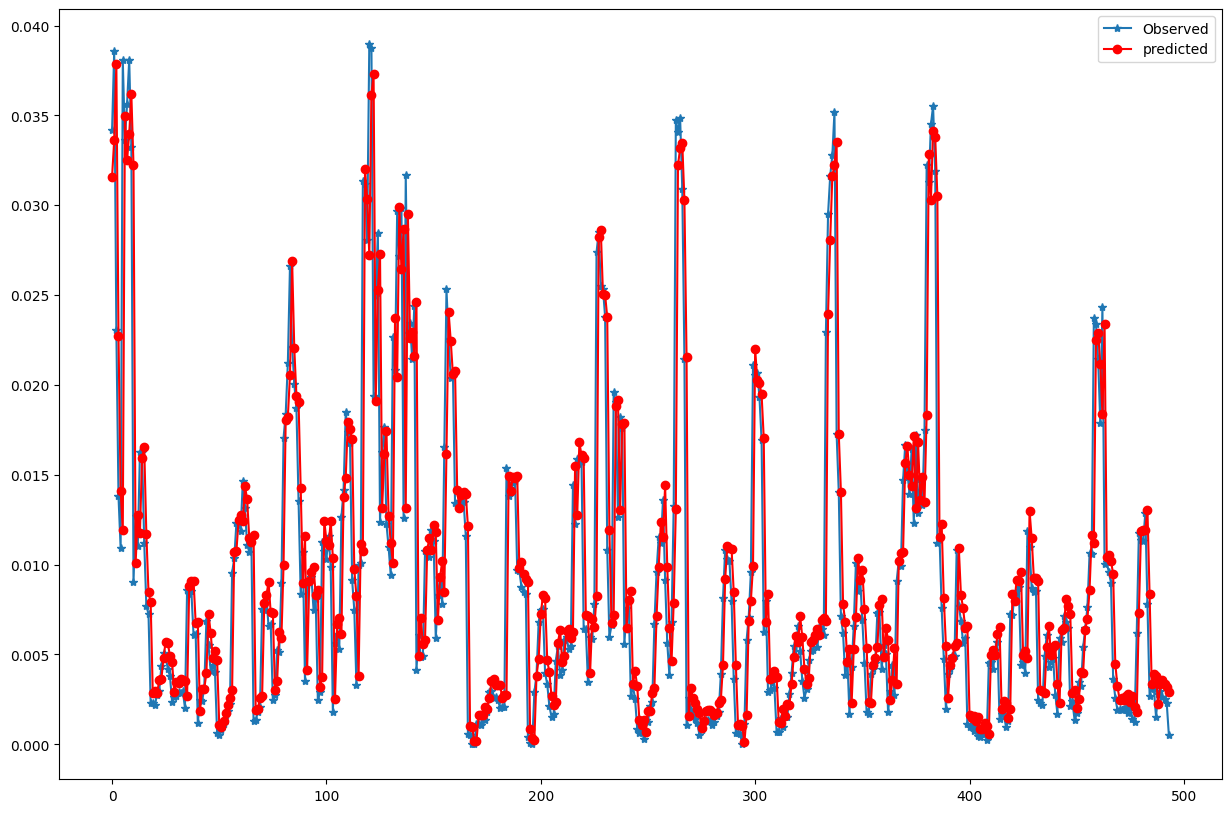

In [19]:
plt.figure(figsize=(15,10))
df = scaler_result.transform(test_outputs)

plt.plot(test_data_df[time_interval:].rv.values**2,marker='*', label = "Observed")
plt.plot(df**2,marker='o', label='predicted', color='red')

plt.legend()


<Figure size 1500x1000 with 0 Axes>

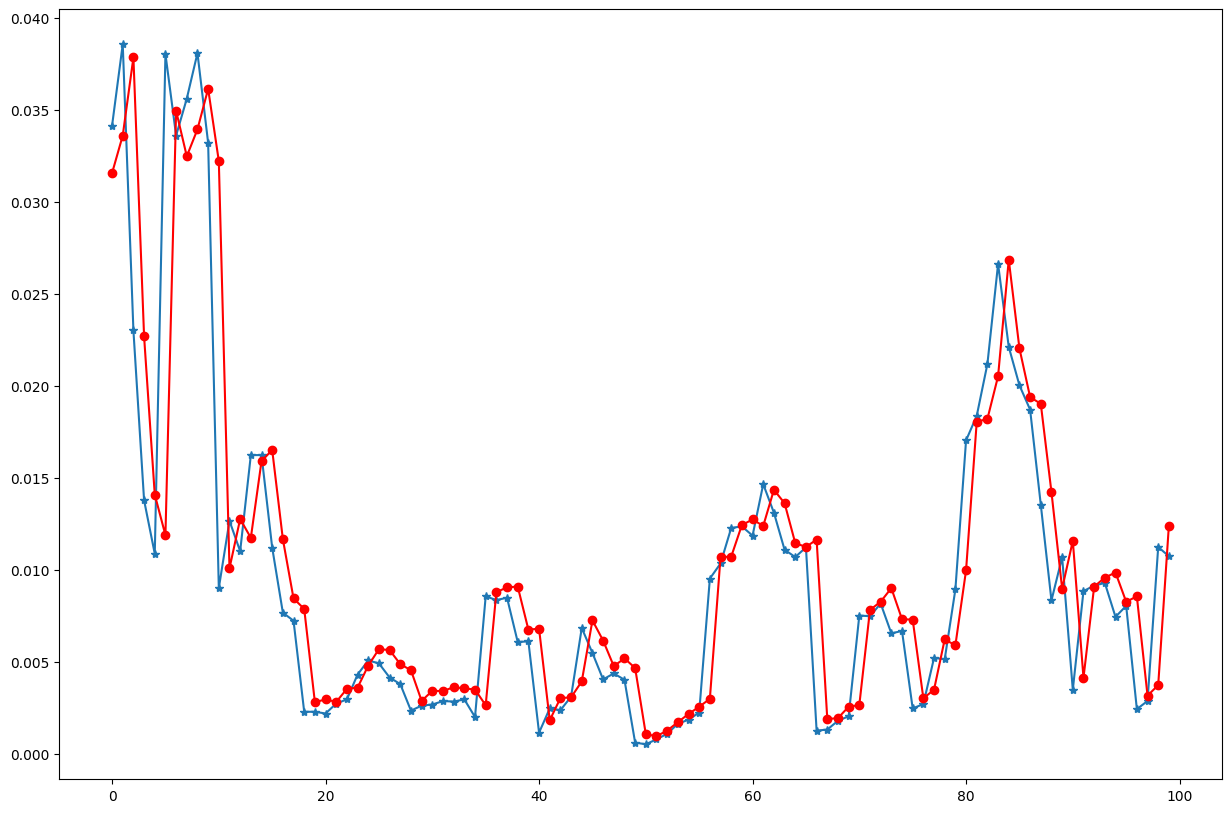

In [22]:
plt.figure(figsize=(15,10))
plt.plot(test_data_df[1:101].rv.values**2,marker='*', label = "Observed")
plt.plot(df[:100]**2,marker='o', label='predicted', color='red')

In [21]:
 from sklearn.metrics import mean_squared_error

mean_squared_error(df,test_data_df[time_interval:].rv.values,squared=False)

0.02259693914755031